#II. Nội dung:

2. Cài đặt và import các thư viện cần thiế

In [1]:
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time
from skimage.util.shape import view_as_blocks
from scipy.spatial.distance import cdist
from scipy.ndimage import convolve, affine_transform
from textwrap import wrap


3. Thêm tọa độ thuần nhất và loại bỏ tọa độ thuần nhất

In [2]:
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])

unpad = lambda x: x[:, :-1]

4. Vẽ các cặp điểm tương đồng (vẽ các điểm đặc trưng tương đồng giữa hai hình ảnh)

In [ ]:
def plot_matches(ax, image1, image2, keypoints1, keypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=True):
    image1.astype(np.float32)
    image2.astype(np.float32)

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
      new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
      new_image2[:image2.shape[0], :image2.shape[1]] = image2
      image2 = new_image2

    image = np.concatenate([image1, image2], axis=1)

    offset = image1.shape

    if not only_matches:
      ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                 facecolor=None, edgecolor=keypoints_color)
      ax.scatter(keypoints2[:, 1] + offset[1], keypoints2[:, 0],
                 facecolor=None, edgecolor=keypoints_color)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, 2 * offset[1], offset[0], 0))

    for i in range(matches.shape[0]):
      idx1 = matches[i, 0]
      idx2 = matches[i, 1]

      if matches_color is None:
        color = np.random.rand(3)
      else:
        color = matches_color
      ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
              (keypoints1[idx1, 0], keypoints2[idx2, 0]),
              '-', color=color)

In [ ]:
image1 = np.zeros((100, 100), dtype=np.uint8)
image2 = np.zeros((100, 100), dtype=np.uint8)

image1[30:70, 40:60] = 255
image2[20:60, 50:70] = 255

keypoints1 = np.array([[40, 50], [60, 50], [50, 40], [50, 60]])
keypoints2 = np.array([[30, 60], [50, 60], [40, 50], [40, 70]])

matches = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])

5. warp_image: biến đổi hình ảnh

In [ ]:
def warp_image(img, H, output_shape, offset):
  Hinv = np.linalg.inv(H)
  m = Hinv.T[:2, :2]
  b = Hinv.T[:2, 2]
  img_warped = affine_transform(img.astype(np.float32), m, b+offset, output_shape, cval=1)
  return img_warped

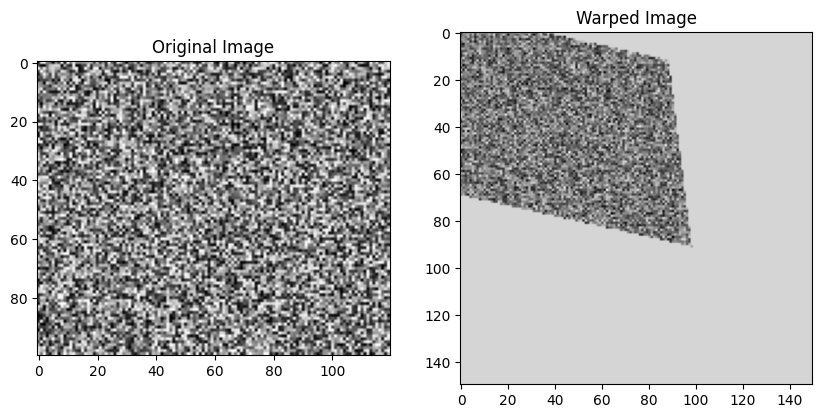

In [ ]:
image = np.random.rand(100, 120)
H = np.array([[0.8, 0.1, 10], [0.2, 0.9, -20], [0, 0, 1]])
output_shape = (150, 150)
offset = (10, 20)
warped_image = warp_image(image, H, output_shape, offset)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(warped_image, cmap='gray')
axes[1].set_title('Warped Image')
plt.show()

6. Cài đặt bộ phát hiện góc Harris để định vị các keypoint:

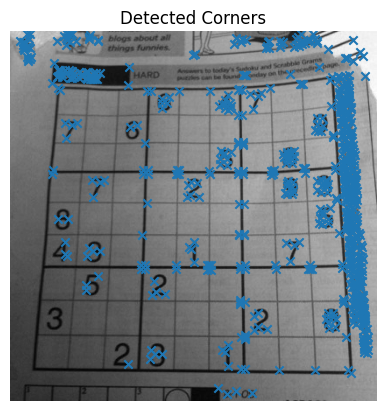

In [ ]:
import numpy as np
from scipy.ndimage import convolve
from skimage import filters, color, io

def harris_corners(img, window_size=3, k=0.04):

    H, W = img.shape
    window = np.ones((window_size, window_size))
    response = np.zeros((H, W))
    dx = filters.sobel_v(img)
    dy = filters.sobel_h(img)

    Ix2 = convolve(dx * dx, window)
    Iy2 = convolve(dy * dy, window)
    Ixy = convolve(dx * dy, window)

    for i in range(H):
        for j in range(W):
            M = np.array([[Ix2[i, j], Ixy[i, j]],
                          [Ixy[i, j], Iy2[i, j]]])

            eigvals = np.linalg.eigvals(M)
            lambda1, lambda2 = eigvals
            response[i, j] = lambda1 * lambda2 - k * (lambda1 + lambda2) ** 2

    return response

img = io.imread('/content/sdk.jpg')
img = color.rgb2gray(img)

response = harris_corners(img)

from skimage.feature import corner_peaks
corners = corner_peaks(response, threshold_rel=0.01)

plt.imshow(img, cmap='gray')
plt.scatter(corners[:, 1], corners[:, 0], marker='x')
plt.axis('off')
plt.title('Detected Corners')
plt.show()


#III. Bài tập:


1. Thực hiện harris_corners lên ảnh image1 và image2:

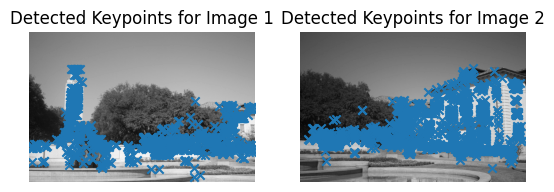

In [ ]:

img1 = imread('uttower1.jpg')
img1 = color.rgb2gray(img1)

img2 = imread('uttower2.jpg')
img2 = color.rgb2gray(img2)

keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()


2. Cài đặt bộ mô tả đơn giản: (Simple Desciptors)

In [ ]:
def simple_descriptor(patch):
    h, w = patch.shape
    feature = patch.reshape(-1)
    mean = np.mean(feature)
    dev = np.std(feature)
    if dev == 0:
        dev = 1
    feature = (feature - mean) / dev
    return feature

In [ ]:
def describe_keypoints(image, keypoints, desc_func, patch_size=16):

    image = image.astype(np.float32)
    desc = []
    for i, kp in enumerate(keypoints):
        y, x = kp
        half_size = patch_size // 2
        patch = image[max(0, y - half_size):min(image.shape[0], y + half_size),
                      max(0, x - half_size):min(image.shape[1], x + half_size)]
        desc.append(desc_func(patch))
    return np.array(desc)


3. Cài đặt phương thức so khớp các keypoint giống nhau:

In [ ]:
def match_descriptors(desc1, desc2, threshold=0.5):
    dists = cdist(desc1, desc2)  # shape (N, M)
    matches = []

    for i in range(desc1.shape[0]):
        sorted_indices = np.argsort(dists[i])
        best_dist = dists[i, sorted_indices[0]]
        second_best_dist = dists[i, sorted_indices[1]]
        if best_dist / second_best_dist < threshold:
            matches.append([i, sorted_indices[0]])
    matches = np.array(matches)
    return matches


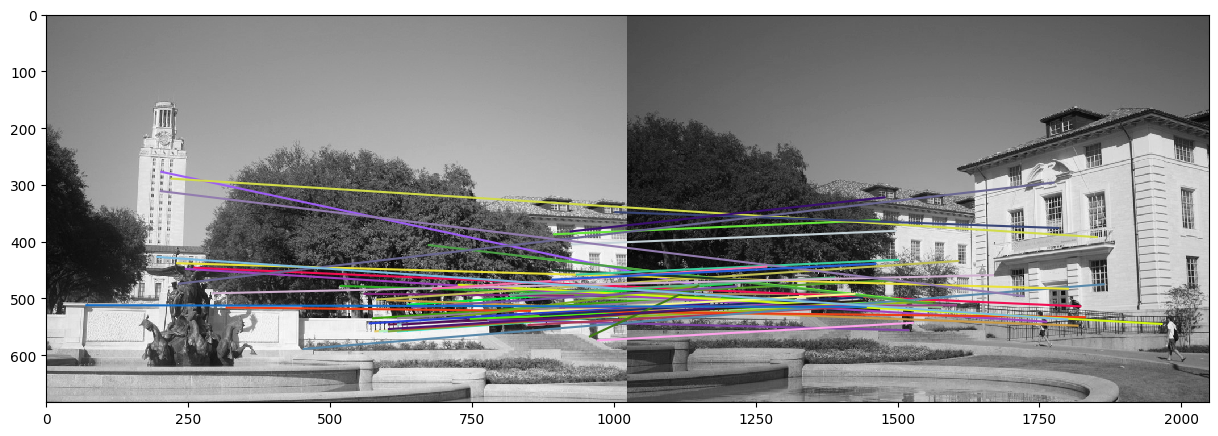

In [ ]:
patch_size = 5

desc1 = describe_keypoints(img1, keypoints1, desc_func=simple_descriptor, patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2, desc_func=simple_descriptor, patch_size=patch_size)

matches = match_descriptors(desc1, desc2, 0.7)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()



4. Tìm ma trận biến đổi hình học:

In [1]:
def fit_affine_matrix(p1, p2):
    assert (p1.shape[0] == p2.shape[0]), 'Different number of points in p1 and p2'
    p1 = pad(p1)
    p2 = pad(p2)
    H, _, _, _ = np.linalg.lstsq(p2, p1, rcond=None)
    H[:, -1] = np.array([0, 0, 1])
    return H

In [ ]:
def get_output_space(img_ref, imgs, transforms):
    assert (len(imgs) == len(transforms))

    r, c = img_ref.shape
    corners = np.array([[0, 0], [r, 0], [0, c], [r, c]])
    all_corners = [corners]

    for i in range(len(imgs)):
        r, c = imgs[i].shape
        H = transforms[i]
        corners = np.array([[0, 0], [r, 0], [0, c], [r, c]])
        warped_corners = corners.dot(H[:2,:2]) + H[2,:2]
        all_corners.append(warped_corners)

    all_corners = np.vstack(all_corners)

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)

    output_shape = np.ceil(output_shape).astype(int)
    offset = corner_min

    return output_shape, offset

Output shape: [ 683 1110]
Offset: [0. 0.]


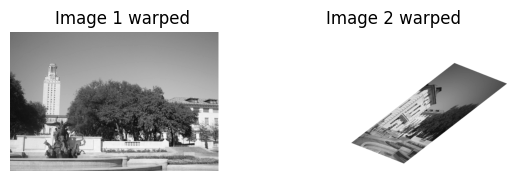

In [ ]:
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)


img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1)
img1_warped[~img1_mask] = 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1)
img2_warped[~img2_mask] = 0

plt.subplot(1,2,1)
plt.imshow(img1_warped, cmap='gray')
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped, cmap='gray')
plt.title('Image 2 warped')
plt.axis('off')

plt.show()


5. RANSAC (RANdom SAmple Consensus):


In [ ]:
def ransac(keypoints1, keypoints2, matches, n_iters=200, threshold=20):

    N = matches.shape[0]
    n_samples = int(N * 0.2)
    matched1 = pad(keypoints1[matches[:, 0]])
    matched2 = pad(keypoints2[matches[:, 1]])

    max_inliers = np.zeros(N)
    n_inliers = 0

    for i in range(n_iters):
        index = np.random.choice(N, n_samples, replace=False)
        p1 = matched1[index, :]
        p2 = matched2[index, :]

        H, _, _, _ = np.linalg.lstsq(p2, p1, rcond=None)
        H[:, 2] = np.array([0, 0, 1])

        transformed_points = np.dot(matched2, H)
        inliers = np.linalg.norm(transformed_points - matched1, axis=1) ** 2 < threshold
        inliers_count = np.sum(inliers)

        if inliers_count > n_inliers:
            max_inliers = inliers.copy()
            n_inliers = inliers_count

    H, _, _, _ = np.linalg.lstsq(matched2[max_inliers], matched1[max_inliers], rcond=None)
    H[:, 2] = np.array([0, 0, 1])

    return H, matches[max_inliers]


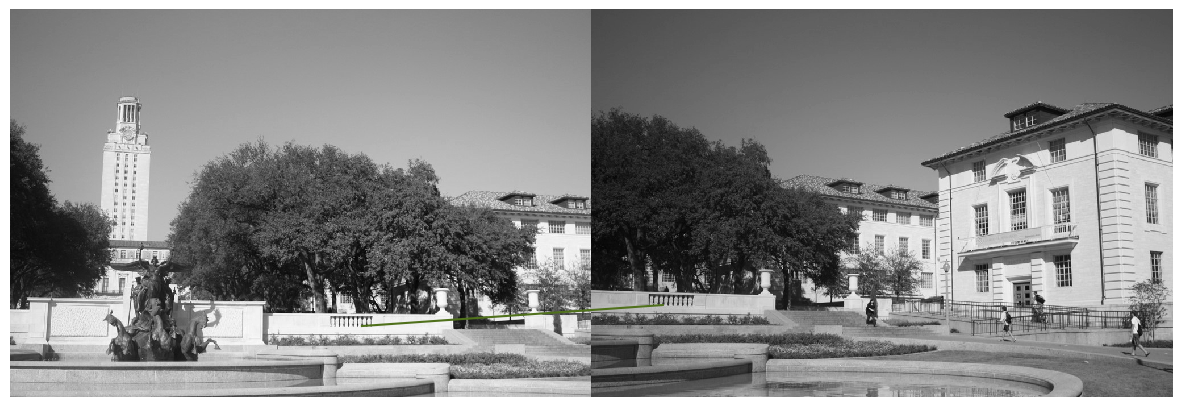

In [ ]:
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

6. Thực hiện ghép hình Panoma cho 4 ảnh bên dưới và cho biết kết
quả thu được:

In [ ]:
output_shape, offset = get_output_space(img1, [img2], [H])

img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1)
img1_warped[~img1_mask] = 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1)
img2_warped[~img2_mask] = 0

plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

LinAlgError: Singular matrix

Bai 6

In [ ]:
img1 = imread('yosemite1.jpg', as_grey=True)
img2 = imread('yosemite2.jpg', as_grey=True)
img3 = imread('yosemite3.jpg', as_grey=True)
img4 = imread('yosemite4.jpg', as_grey=True)

keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints3 = corner_peaks(harris_corners(img3, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints4 = corner_peaks(harris_corners(img4, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)


desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc3 = describe_keypoints(img3, keypoints3,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc4 = describe_keypoints(img4, keypoints4,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

matches12 = match_descriptors(desc1, desc2, 0.7)
matches23 = match_descriptors(desc2, desc3, 0.7)
matches34 = match_descriptors(desc3, desc4, 0.7)


H12, robust_matches12 = ransac(keypoints1, keypoints2, matches12, threshold=1)
H23, robust_matches23 = ransac(keypoints2, keypoints3, matches23, threshold=1)
H34, robust_matches34 = ransac(keypoints3, keypoints4, matches34, threshold=1)
2
output_shape, offset = get_output_space(img2, [img1, img3, img4], [np.linalg.inv(H12), H23, np.dot(H23,H34)])


img1_warped = warp_image(img1, np.linalg.inv(H12), output_shape, offset)
img1_mask = (img1_warped != -1)
img1_warped[~img1_mask] = 0
img2_warped = warp_image(img2, np.eye(3), output_shape, offset)
img2_mask = (img2_warped != -1)
img2_warped[~img2_mask] = 0

img3_warped = warp_image(img3, H23, output_shape, offset)
img3_mask = (img3_warped != -1)
img3_warped[~img3_mask] = 0

img4_warped = warp_image(img4,  np.dot(H23,H34), output_shape, offset)
img4_mask = (img4_warped != -1)
img4_warped[~img4_mask] = 0

plt.imshow(img1_warped)
plt.axis('off')
plt.title('Image 1 warped')
plt.show()

plt.imshow(img2_warped)
plt.axis('off')
plt.title('Image 2 warped')
plt.show()

plt.imshow(img3_warped)
plt.axis('off')
plt.title('Image 3 warped')
plt.show()

plt.imshow(img4_warped)
plt.axis('off')
plt.title('Image 4 warped')
plt.show()

